In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,UpSampling2D,Dropout
from tensorflow.keras.models import Model

In [2]:
mkdir checkpoints

In [3]:
X = np.load("../input/teeth-segmentation-npy-files/X.npy")
Y = np.load("../input/teeth-segmentation-npy-files/Y.npy")
X.shape, Y.shape

((464, 512, 512, 1), (464, 512, 512, 1))

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

In [5]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((371, 512, 512, 1), (93, 512, 512, 1), (371, 512, 512, 1), (93, 512, 512, 1))

In [6]:
def UNET (input_shape=(512,512,1),last_activation='sigmoid'):
    model = Sequential()

    #Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    #Decoder
    model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))
    
    return model

model = UNET()
model.summary()

2022-09-22 11:52:34.530193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 11:52:34.632501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 11:52:34.633411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 11:52:34.635066: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      2

In [7]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    
    return intersection/union

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, 1)

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

In [8]:
import tensorflow as tf
model_ckt = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoints/",
    monitor='val_accuracy',
    verbose = 1,
    save_best_only=False,
    save_weights_only=True,
    mode='max',
    save_freq='epoch',
)
learningrate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                           mode = 'max',
                                                           factor = 0.1, 
                                                           patience = 20, 
                                                           verbose = 1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                 patience = 20, 
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                  verbose=1)

callbacks_list = [learningrate_scheduler, early_stopping, model_ckt]

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', dice_coef, IOU, specificity,
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.Precision(name='precision')])

history = model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          batch_size=8,
          epochs=200,
          verbose=1,
          callbacks = callbacks_list)

2022-09-22 11:52:39.558833: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-09-22 11:52:42.711446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


47/47 [==============================] - 19s 185ms/step - loss: 0.4770 - accuracy: 0.8015 - dice_coef: 0.5330 - IOU: 0.3657 - specificity: 0.8524 - recall: 0.8391 - precision: 0.6823 - val_loss: 0.5036 - val_accuracy: 0.7144 - val_dice_coef: 0.2445 - val_IOU: 0.1393 - val_specificity: 0.9495 - val_recall: 0.0063 - val_precision: 0.0384

Epoch 00001: saving model to ./checkpoints/
Epoch 2/200
47/47 [==============================] - 6s 134ms/step - loss: 0.3480 - accuracy: 0.8484 - dice_coef: 0.6033 - IOU: 0.4322 - specificity: 0.9046 - recall: 0.8681 - precision: 0.7974 - val_loss: 0.4802 - val_accuracy: 0.6841 - val_dice_coef: 0.4131 - val_IOU: 0.2606 - val_specificity: 0.6966 - val_recall: 0.9020 - val_precision: 0.5095

Epoch 00002: saving model to ./checkpoints/
Epoch 3/200
47/47 [==============================] - 6s 132ms/step - loss: 0.2865 - accuracy: 0.8568 - dice_coef: 0.6442 - IOU: 0.4758 - specificity: 0.9199 - recall: 0.8483 - precision: 0.8273 - val_loss: 0.7653 - val_accu

In [10]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("model_history.csv")

In [11]:
hist_df

,loss,accuracy,dice_coef,IOU,specificity,recall,precision,val_loss,val_accuracy,val_dice_coef,val_IOU,val_specificity,val_recall,val_precision,lr
0,0.477019,0.801522,0.533023,0.365687,0.852358,0.839145,0.682269,0.503581,0.714395,0.244451,0.139298,0.949479,0.006274,0.038432,0.00100
1,0.347976,0.848399,0.603263,0.432240,0.904593,0.868053,0.797358,0.480155,0.684076,0.413101,0.260561,0.696569,0.901993,0.509464,0.00100
2,0.286525,0.856777,0.644166,0.475790,0.919904,0.848309,0.827255,0.765345,0.752267,0.054812,0.028177,1.000000,0.000000,0.000000,0.00100
3,0.244492,0.863980,0.676208,0.511007,0.929677,0.844985,0.851019,0.759484,0.752267,0.056492,0.029066,1.000000,0.000000,0.000000,0.00100
4,0.218076,0.867329,0.693085,0.530661,0.934999,0.840880,0.862235,0.591093,0.752267,0.124415,0.066336,1.000000,0.000000,0.000000,0.00100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0.036873,0.915985,0.945006,0.895750,0.995026,0.868367,0.996399,0.099949,0.904075,0.912551,0.839435,0.983262,0.851899,0.973381,0.00001
169,0.036857,0.916006,0.944965,0.895676,0.995016,0.868410,0.996479,0.099990,0.904086,0.912673,0.839642,0.983126,0.852743,0.973256,0.00001
170,0.036862,0.915990,0.945025,0.895785,0.995034,0.868274,0.996443,0.099968,0.904090,0.912684,0.839661,0.983138,0.852795,0.973298,0.00001
171,0.036871,0.915989,0.945006,0.895748,0.994973,0.868771,0.996396,0.099937,0.904077,0.912597,0.839515,0.983198,0.852298,0.973318,0.00001


In [12]:
model.save('unet_six.h5')

In [13]:
pred = model.predict(X_test)
pred.shape

(93, 512, 512, 1)

In [14]:
from sklearn.metrics import f1_score
import numpy as np

predict_img1=(pred>0.25)*1
y_test1=(Y_test>0.25)*1
f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9721407326318885

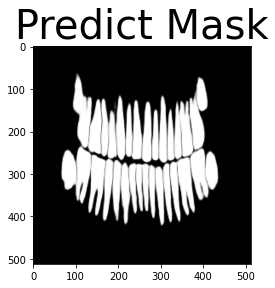

In [15]:
plt.title("Predict Mask",fontsize = 40)
plt.imshow(pred[50,:,:,0], cmap='gray')

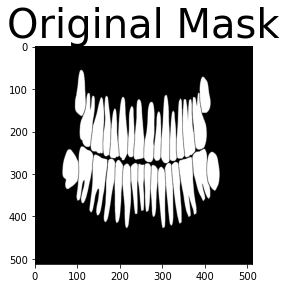

In [16]:
plt.title("Original Mask",fontsize = 40)
plt.imshow(Y_test[50,:,:,0], cmap='gray')